In [ ]:
"""%%capture

# Install the 'einops' library for easy manipulation of tensors
!pip install einops

# Install the 'lpips' library for computing perceptual similarity between images
!pip install lpips"""

"%%capture\n\n# Install the 'einops' library for easy manipulation of tensors\n!pip install einops\n\n# Install the 'lpips' library for computing perceptual similarity between images\n!pip install lpips"

In [1]:
# Import the PyTorch library for tensor operations.
import torch

# Import the neural network module from PyTorch.
import torch.nn as nn

# Import functional operations from PyTorch.
import torch.nn.functional as F

# Import the 'numpy' library for numerical operations.
import numpy as np

# Import the 'functools' module for higher-order functions.
import functools

# Import the Adam optimizer from PyTorch.
from torch.optim import Adam

# Import the DataLoader class from PyTorch for handling datasets.
from torch.utils.data import DataLoader

# Import data transformation functions from torchvision.
import torchvision.transforms as transforms

# Import the MNIST dataset from torchvision.
from torchvision.datasets import MNIST,FashionMNIST,CIFAR10,Flowers102,OxfordIIITPet,CIFAR100

# Import 'tqdm' for creating progress bars during training.
import tqdm

# Import 'trange' and 'tqdm' specifically for notebook compatibility.
from tqdm.notebook import trange, tqdm

# Import the learning rate scheduler from PyTorch.
from torch.optim.lr_scheduler import MultiplicativeLR, LambdaLR

# Import the 'matplotlib.pyplot' library for plotting graphs.
import matplotlib.pyplot as plt

# Import the 'make_grid' function from torchvision.utils for visualizing image grids.
from torchvision.utils import make_grid

# Importing the `rearrange` function from the `einops` library
from einops import rearrange

# Importing the `math` module for mathematical operations
import math

In [2]:
# Forward diffusion for N steps in 1D.
def forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - t0: Initial time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = t0 + np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for diffusion simulation
    for i in range(nsteps):

        # Get the noise strength at the current time
        noise_strength = noise_strength_fn(t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using Euler-Maruyama method
        x[i + 1] = x[i] + random_normal * noise_strength

    # Return the trajectory and corresponding time points
    return x, t

In [3]:
# Example noise strength function: always equal to 1
def noise_strength_constant(t):
    """
    Example noise strength function that returns a constant value (1).

    Parameters:
    - t: Time parameter (unused in this example)

    Returns:
    - Constant noise strength (1)
    """
    return 1

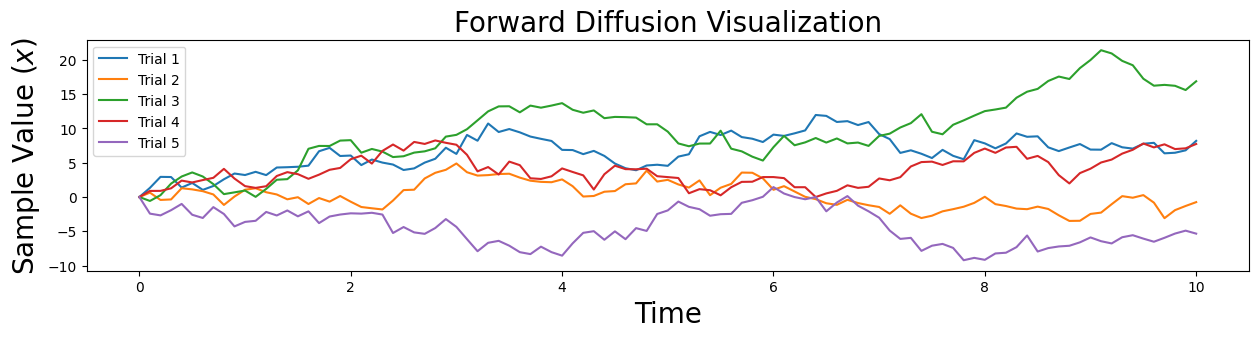

In [4]:
# Number of diffusion steps
nsteps = 100

# Initial time
t0 = 0

# Time step size
dt = 0.1

# Noise strength function
noise_strength_fn = noise_strength_constant

# Initial sample value
x0 = 0

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):

    # Simulate forward diffusion
    x, t = forward_diffusion_1D(x0, noise_strength_fn, t0, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Forward Diffusion Visualization', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()


In [5]:
# Reverse diffusion for N steps in 1D.
def reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt):
    """
    Parameters:
    - x0: Initial sample value (scalar)
    - noise_strength_fn: Function of time, outputs scalar noise strength
    - score_fn: Score function
    - T: Final time
    - nsteps: Number of diffusion steps
    - dt: Time step size

    Returns:
    - x: Trajectory of sample values over time
    - t: Corresponding time points for the trajectory
    """

    # Initialize the trajectory array
    x = np.zeros(nsteps + 1)

    # Set the initial sample value
    x[0] = x0

    # Generate time points for the trajectory
    t = np.arange(nsteps + 1) * dt

    # Perform Euler-Maruyama time steps for reverse diffusion simulation
    for i in range(nsteps):

        # Calculate noise strength at the current time
        noise_strength = noise_strength_fn(T - t[i])

        # Calculate the score using the score function
        score = score_fn(x[i], 0, noise_strength, T - t[i])

        # Generate a random normal variable
        random_normal = np.random.randn()

        # Update the trajectory using the reverse Euler-Maruyama method
        x[i + 1] = x[i] + score * noise_strength**2 * dt + noise_strength * random_normal * np.sqrt(dt)

    # Return the trajectory and corresponding time points
    return x, t

In [6]:
# Example score function: always equal to 1
def score_simple(x, x0, noise_strength, t):
    """
    Parameters:
    - x: Current sample value (scalar)
    - x0: Initial sample value (scalar)
    - noise_strength: Scalar noise strength at the current time
    - t: Current time

    Returns:
    - score: Score calculated based on the provided formula
    """

    # Calculate the score using the provided formula
    score = - (x - x0) / ((noise_strength**2) * t)

    # Return the calculated score
    return score

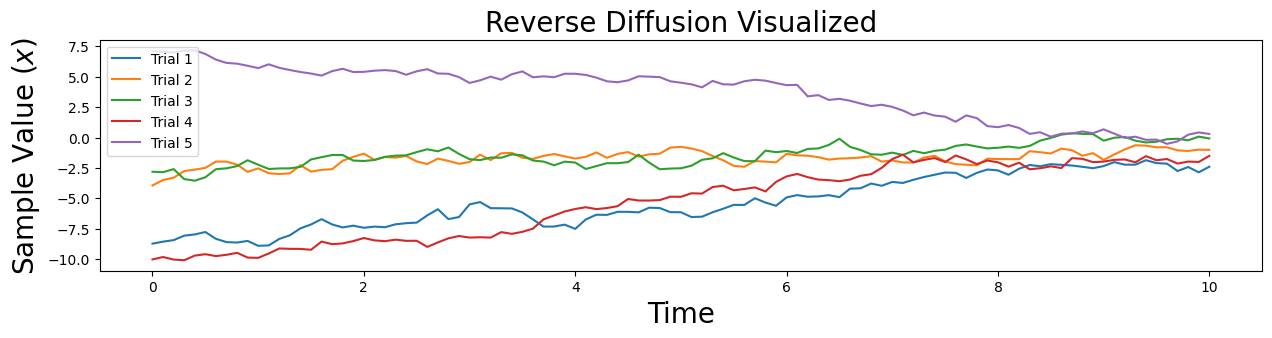

In [7]:
# Number of reverse diffusion steps
nsteps = 100

# Initial time for reverse diffusion
t0 = 0

# Time step size for reverse diffusion
dt = 0.1

# Function defining constant noise strength for reverse diffusion
noise_strength_fn = noise_strength_constant

# Example score function for reverse diffusion
score_fn = score_simple

# Initial sample value for reverse diffusion
x0 = 0

# Final time for reverse diffusion
T = 11

# Number of tries for visualization
num_tries = 5

# Setting larger width and smaller height for the plot
plt.figure(figsize=(15, 3))

# Loop for multiple trials
for i in range(num_tries):
    # Draw from the noise distribution, which is diffusion for time T with noise strength 1
    x0 = np.random.normal(loc=0, scale=T)

    # Simulate reverse diffusion
    x, t = reverse_diffusion_1D(x0, noise_strength_fn, score_fn, T, nsteps, dt)

    # Plot the trajectory
    plt.plot(t, x, label=f'Trial {i+1}')  # Adding a label for each trial

# Labeling the plot
plt.xlabel('Time', fontsize=20)
plt.ylabel('Sample Value ($x$)', fontsize=20)

# Title of the plot
plt.title('Reverse Diffusion Visualized', fontsize=20)

# Adding a legend to identify each trial
plt.legend()

# Show the plot
plt.show()

In [8]:
# Define a module for Gaussian random features used to encode time steps.
class GaussianFourierProjection(nn.Module):
    def __init__(self, embed_dim, scale=30.):
        """
        Parameters:
        - embed_dim: Dimensionality of the embedding (output dimension)
        - scale: Scaling factor for random weights (frequencies)
        """
        super().__init__()

        # Randomly sample weights (frequencies) during initialization.
        # These weights (frequencies) are fixed during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor representing time steps
        """
        # Calculate the cosine and sine projections: Cosine(2 pi freq x), Sine(2 pi freq x)
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi

        # Concatenate the sine and cosine projections along the last dimension
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

In [9]:
# Define a module for a fully connected layer that reshapes outputs to feature maps.
class Dense(nn.Module):
    def __init__(self, input_dim, output_dim):
        """
        Parameters:
        - input_dim: Dimensionality of the input features
        - output_dim: Dimensionality of the output features
        """
        super().__init__()

        # Define a fully connected layer
        self.dense = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        """
        Parameters:
        - x: Input tensor

        Returns:
        - Output tensor after passing through the fully connected layer
          and reshaping to a 4D tensor (feature map)
        """

        # Apply the fully connected layer and reshape the output to a 4D tensor
        return self.dense(x)[..., None, None]
        # This broadcasts the 2D tensor to a 4D tensor, adding the same value across space.

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, marginal_prob_std, channels=[64, 128, 256, 512], embed_dim=256):
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False)  # padding=1 to maintain size
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(8, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)  # stride=2 to halve size
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(16, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2] * 2, channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(16, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1] * 2, channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(8, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0] * 2, 3, 3, stride=1, padding=1, bias=False)  # Output 3 channels for RGB

        # Activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        # Time embedding
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))

        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))

        # Ensure h and h3 have the same spatial dimensions
        if h.shape[2:] != h3.shape[2:]:
            h = F.interpolate(h, size=h3.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv3(torch.cat([h, h3], dim=1))
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))

        # Ensure h and h2 have the same spatial dimensions
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv2(torch.cat([h, h2], dim=1))
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))

        # Ensure h and h1 have the same spatial dimensions
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv1(torch.cat([h, h1], dim=1))

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [11]:
# Using GPU
device = "cuda"

# Marginal Probability Standard Deviation Function
def marginal_prob_std(t, sigma):
    """
    Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The standard deviation.
    """
    # Convert time steps to a PyTorch tensor
    t = torch.tensor(t, device=device)

    # Calculate and return the standard deviation based on the given formula
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))

In [12]:
# Using GPU
device = "cuda"

def diffusion_coeff(t, sigma):
    """
    Compute the diffusion coefficient of our SDE.

    Parameters:
    - t: A vector of time steps.
    - sigma: The $\sigma$ in our SDE.

    Returns:
    - The vector of diffusion coefficients.
    """
    # Calculate and return the diffusion coefficients based on the given formula
    return torch.tensor(sigma**t, device=device)


In [13]:
# Sigma Value
sigma =  25.0

# marginal probability standard
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)

# diffusion coefficient
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [14]:
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """
    The loss function for training score-based generative models.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.
    """
    # Sample time uniformly in the range (eps, 1-eps)
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - 2 * eps) + eps
    # Find the noise std at the sampled time `t`
    std = marginal_prob_std(random_t)

    # Generate normally distributed noise
    z = torch.randn_like(x)

    # Perturb the input data with the generated noise
    perturbed_x = x + z * std[:, None, None, None]

    # Get the score from the model using the perturbed data and time
    score = model(perturbed_x, random_t)

    # Calculate the loss based on the score and noise
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))

    return loss

In [15]:
# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(3, 32, 32),  # Updated to 3 channels and 32x32 resolution
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3, y=None):


    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x

In [16]:
# Define the score-based model and move it to the specified device
score_model = torch.nn.DataParallel(UNet(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Number of training epochs
n_epochs = 50
# Size of a mini-batch
batch_size = 2048
# Learning rate
lr = 5e-4

# Load the MNIST dataset and create a data loader
dataset = CIFAR10('.', train=True, transform=transforms.ToTensor(), download=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)

# Define the Adam optimizer for training the model
optimizer = Adam(score_model.parameters(), lr=lr)

# Progress bar for epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate through mini-batches in the data loader
    for x, y in tqdm(data_loader):
        x = x.to(device)
        # Calculate the loss and perform backpropagation
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
    # Print the averaged training loss for the current epoch
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))
    # Save the model checkpoint after each epoch of training
    torch.save(score_model.state_dict(), 'ckpt.pth')

 38%|███▊      | 64.0M/170M [00:01<00:02, 36.5MB/s]


KeyboardInterrupt: 

In [17]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('/content/ckpt (1).pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 64
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/content/ckpt (1).pth'

In [ ]:
# Define a time-dependent score-based model built upon the U-Net architecture.
class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])
        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])
        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])
        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])
        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)
        self.h13 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2)

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet_res(nn.Module):
    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256):
        """
        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings.
        """

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False)  # padding=1 to maintain size
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)  # stride=2 to halve size
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 3, 3, stride=1, padding=1, bias=False)  # Output 3 channels for RGB

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std

    def forward(self, x, t, y=None):
        """
        Parameters:
        - x: Input tensor (3-channel RGB image)
        - t: Time tensor
        - y: Target tensor (not used in this forward pass)

        Returns:
        - h: Output tensor after passing through the U-Net architecture
        """

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))

        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))

        # Decoding path
        h = self.tconv4(h4)
        h += self.dense5(embed)
        h = self.act(self.tgnorm4(h))

        # Ensure h and h3 have the same spatial dimensions
        if h.shape[2:] != h3.shape[2:]:
            h = F.interpolate(h, size=h3.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv3(h + h3)
        h += self.dense6(embed)
        h = self.act(self.tgnorm3(h))

        # Ensure h and h2 have the same spatial dimensions
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv2(h + h2)
        h += self.dense7(embed)
        h = self.act(self.tgnorm2(h))

        # Ensure h and h1 have the same spatial dimensions
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [ ]:
# Initialize the alternate U-Net model for training.
score_model = torch.nn.DataParallel(UNet_res(marginal_prob_std=marginal_prob_std_fn))
score_model = score_model.to(device)

# Set the number of training epochs, mini-batch size, and learning rate.
n_epochs = 100
batch_size = 1024
lr = 1e-3
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224)
])
train_dataset = OxfordIIITPet(
    root='./data',       # Путь к папке с данными
    split='trainval',       # Указываем, что загружаем обучающий набор
    transform=transform, # Применяем преобразования
    download=True        # Скачиваем данные, если они отсутствуют
)
# Load the MNIST dataset for training.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
state_dict = torch.load("/content/ckpt_res1.pth", map_location=device, weights_only=True)
score_model.load_state_dict(torch.load("/content/ckpt_res1.pth", map_location=device, weights_only=True))

# Initialize the Adam optimizer with the specified learning rate.
optimizer = Adam(score_model.parameters(), lr=lr)
# Learning rate scheduler to adjust the learning rate during training.
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))

# Training loop over epochs.
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0
    # Iterate over mini-batches in the training data loader.
    for x, y in data_loader:
        x = x.to(device)
        # Compute the loss for the current mini-batch.
        loss = loss_fn(score_model, x, marginal_prob_std_fn)
        # Zero the gradients, backpropagate, and update the model parameters.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Accumulate the total loss and the number of processed items.
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]

    # Adjust the learning rate using the scheduler.
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]

    # Print the average loss and learning rate for the current epoch.
    print('{} Average Loss: {:5f} lr {:.1e}'.format(epoch, avg_loss / num_items, lr_current))
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

    # Save the model checkpoint after each epoch of training.
    torch.save(score_model.state_dict(), 'ckpt_res2.pth')

In [ ]:
score_model.load_state_dict(torch.load('/content/ckpt_res.pth'))

In [ ]:
# Load the pre-trained checkpoint from disk.
device = 'cuda'

# Load the pre-trained model checkpoint
ckpt = torch.load('ckpt_res2.pth', map_location=device)
score_model.load_state_dict(ckpt)

# Set sample batch size and number of steps
sample_batch_size = 1
num_steps = 500

# Choose the Euler-Maruyama sampler
sampler = Euler_Maruyama_sampler

# Generate samples using the specified sampler
samples = sampler(score_model,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  num_steps=num_steps,
                  device=device,
                  y=None)

# Clip samples to be in the range [0, 1]
samples = samples.clamp(0.0, 1.0)

# Visualize the generated samples
%matplotlib inline
import matplotlib.pyplot as plt
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the sample grid
plt.figure(figsize=(6, 6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [18]:
class CrossAttention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, context_dim=None, num_heads=1):
        """
        Initialize the CrossAttention module.

        Parameters:
        - embed_dim: The dimensionality of the output embeddings.
        - hidden_dim: The dimensionality of the hidden representations.
        - context_dim: The dimensionality of the context representations (if not self attention).
        - num_heads: Number of attention heads (currently supports 1 head).

        Note: For simplicity reasons, the implementation assumes 1-head attention.
        Feel free to implement multi-head attention using fancy tensor manipulations.
        """
        super(CrossAttention, self).__init__()

        self.hidden_dim = hidden_dim
        self.context_dim = context_dim
        self.embed_dim = embed_dim


        # Linear layer for query projection
        self.query = nn.Linear(hidden_dim, embed_dim, bias=False)

        # Check if self-attention or cross-attention
        if context_dim is None:
            self.self_attn = True
            self.key = nn.Linear(hidden_dim, embed_dim, bias=False)
            self.value = nn.Linear(hidden_dim, hidden_dim, bias=False)
        else:
            self.self_attn = False
            self.key = nn.Linear(context_dim, embed_dim, bias=False)
            self.value = nn.Linear(context_dim, hidden_dim, bias=False)

    def forward(self, tokens, context=None):
        """
        Forward pass of the CrossAttention module.

        Parameters:
        - tokens: Input tokens with shape [batch, sequence_len, hidden_dim].
        - context: Context information with shape [batch, context_seq_len, context_dim].
                    If self_attn is True, context is ignored.

        Returns:
        - ctx_vecs: Context vectors after attention with shape [batch, sequence_len, embed_dim].
        """

        if self.self_attn:
            # Self-attention case
            Q = self.query(tokens)
            K = self.key(tokens)
            V = self.value(tokens)
        else:
            # Cross-attention case
            Q = self.query(tokens)
            K = self.key(context)
            V = self.value(context)

        # Compute score matrices, attention matrices, and context vectors
        scoremats = torch.einsum("BTH,BSH->BTS", Q, K)  # Inner product of Q and K, a tensor
        attnmats = F.softmax(scoremats / math.sqrt(self.embed_dim), dim=-1)  # Softmax of scoremats
        ctx_vecs = torch.einsum("BTS,BSH->BTH", attnmats, V)  # Weighted average value vectors by attnmats

        return ctx_vecs

In [19]:
class TransformerBlock(nn.Module):
    """The transformer block that combines self-attn, cross-attn, and feed forward neural net"""
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the TransformerBlock.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.

        Note: For simplicity, the self-attn and cross-attn use the same hidden_dim.
        """

        super(TransformerBlock, self).__init__()

        # Self-attention module
        self.attn_self = CrossAttention(hidden_dim, hidden_dim)

        # Cross-attention module
        self.attn_cross = CrossAttention(hidden_dim, hidden_dim, context_dim)

        # Layer normalization modules
        self.norm1 = nn.LayerNorm(hidden_dim)
        self.norm2 = nn.LayerNorm(hidden_dim)
        self.norm3 = nn.LayerNorm(hidden_dim)

        # Implement a 2-layer MLP with K * hidden_dim hidden units, and nn.GELU nonlinearity
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, 3 * hidden_dim),
            nn.GELU(),
            nn.Linear(3 * hidden_dim, hidden_dim)
        )

    def forward(self, x, context=None):
        """
        Forward pass of the TransformerBlock.

        Parameters:
        - x: Input tensor with shape [batch, sequence_len, hidden_dim].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after passing through the TransformerBlock.
        """

        # Apply self-attention with layer normalization and residual connection
        x = self.attn_self(self.norm1(x)) + x

        # Apply cross-attention with layer normalization and residual connection
        x = self.attn_cross(self.norm2(x), context=context) + x

        # Apply feed forward neural network with layer normalization and residual connection
        x = self.ffn(self.norm3(x)) + x

        return x

In [20]:
class SpatialTransformer(nn.Module):
    def __init__(self, hidden_dim, context_dim):
        """
        Initialize the SpatialTransformer.

        Parameters:
        - hidden_dim: The dimensionality of the hidden state.
        - context_dim: The dimensionality of the context tensor.
        """
        super(SpatialTransformer, self).__init__()

        # TransformerBlock for spatial transformation
        self.transformer = TransformerBlock(hidden_dim, context_dim)

    def forward(self, x, context=None):
        """
        Forward pass of the SpatialTransformer.

        Parameters:
        - x: Input tensor with shape [batch, channels, height, width].
        - context: Context tensor with shape [batch, context_seq_len, context_dim].

        Returns:
        - x: Output tensor after applying spatial transformation.
        """
        b, c, h, w = x.shape
        x_in = x

        # Combine the spatial dimensions and move the channel dimension to the end
        x = rearrange(x, "b c h w -> b (h w) c")

        # Apply the sequence transformer
        x = self.transformer(x, context)

        # Reverse the process
        x = rearrange(x, 'b (h w) c -> b c h w', h=h, w=w)

        # Residue connection
        return x + x_in

In [21]:

class Expert(nn.Module):

    def __init__(self, in_channels, out_channels):
        super(Expert, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, stride=1, padding=1)
        self.act = nn.SiLU()

    def forward(self, x):
        x = self.act(self.conv1(x))
        x = self.act(self.conv2(x))
        return x

class VisionMoE(nn.Module):

    def __init__(self, in_channels, out_channels, num_experts=4):
        super(VisionMoE, self).__init__()
        self.num_experts = num_experts
        self.experts = nn.ModuleList([Expert(in_channels, out_channels) for _ in range(num_experts)])
        self.gate = nn.Linear(in_channels, num_experts)

    def forward(self, x):
        # Split the input into parts for each expert
        B, C, H, W = x.shape
        x_parts = torch.chunk(x, self.num_experts, dim=2)  # Split along height

        # Process each part with the corresponding expert
        expert_outputs = []
        for i, x_part in enumerate(x_parts):
            expert_outputs.append(self.experts[i](x_part))

        # Combine the outputs
        combined_output = torch.cat(expert_outputs, dim=2)
        return combined_output

In [22]:
import torch
import torch.nn as nn
num_experts = 4
class UNet_Transformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                 text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, bias=False)  # Change input channels to 3 for RGB
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.vision_moe = VisionMoE(channels[2], channels[2], num_experts=num_experts)
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 3, 3, stride=1)  # Change output channels to 3 for RGB

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor (3-channel RGB image).
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)

        h0 = self.vision_moe(h3)
        h4 = self.conv4(h0) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        if h.shape[2:] != h4.shape[2:]:
            h = F.interpolate(h, size=h4.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        if h.shape[2:] != h3.shape[2:]:
            h = F.interpolate(h, size=h4.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h4.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h4.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h


In [ ]:
"""class UNet_Tranformerr(nn.Module):


    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                  text_dim=256, nClass=10):

        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, bias=False)
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])
        self.tconv1 = nn.ConvTranspose2d(channels[0], 1, 3, stride=1)

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):

        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))
        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))
        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)
        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))
        h = nn.functional.interpolate(h, size=h3.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h
"""

"class UNet_Tranformerr(nn.Module):\n\n\n    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,\n                  text_dim=256, nClass=10):\n\n        super().__init__()\n\n        # Gaussian random feature embedding layer for time\n        self.time_embed = nn.Sequential(\n            GaussianFourierProjection(embed_dim=embed_dim),\n            nn.Linear(embed_dim, embed_dim)\n        )\n\n        # Encoding layers where the resolution decreases\n        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, bias=False)\n        self.dense1 = Dense(embed_dim, channels[0])\n        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])\n\n        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)\n        self.dense2 = Dense(embed_dim, channels[1])\n        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])\n\n        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)\n        self.dense3 = Dense(embed_di

In [23]:
def loss_fn_cond(model, x, y, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models with conditional information.

    Parameters:
    - model: A PyTorch model instance that represents a time-dependent score-based model.
    - x: A mini-batch of training data.
    - y: Conditional information (target tensor).
    - marginal_prob_std: A function that gives the standard deviation of the perturbation kernel.
    - eps: A tolerance value for numerical stability.

    Returns:
    - loss: The calculated loss.
    """
    # Sample time uniformly in the range [eps, 1-eps]
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps
    # Generate random noise with the same shape as the input
    z = torch.randn_like(x)
    # Compute the standard deviation of the perturbation kernel at the sampled time
    std = marginal_prob_std(random_t)
    # Perturb the input data with the generated noise and scaled by the standard deviation
    perturbed_x = x + z * std[:, None, None, None]
    # Get the model's score for the perturbed input, considering conditional information
    score = model(perturbed_x, random_t, y=y)
    # Calculate the loss using the score and perturbation
    loss = torch.mean(torch.sum((score * std[:, None, None, None] + z)**2, dim=(1, 2, 3)))
    return loss

In [24]:
import torch
from transformers import CLIPProcessor, CLIPModel

# Загрузка предобученной модели CLIP и процессора
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def text_to_vector(text, max_length=1):
    """
    Переводит текст в вектор с использованием модели CLIP.

    Parameters:
    - text: Входной текст (строка).
    - max_length: Максимальная длина текстового вектора (по умолчанию 100).

    Returns:
    - text_vector: Тензор с векторным представлением текста размерности torch.Size([100]).
    """
    # Токенизация текста и подготовка входных данных для модели
    inputs = processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=max_length)

    # Получение векторного представления текста
    with torch.no_grad():
        text_features = model.get_text_features(**inputs)

    # Приведение размерности к torch.Size([100])
    text_vector = text_features.squeeze(0)  # Убираем batch dimension
    if text_vector.shape[0] > max_length:
        text_vector = text_vector[:max_length]
    elif text_vector.shape[0] < max_length:
        padding = torch.zeros(max_length - text_vector.shape[0])
        text_vector = torch.cat([text_vector, padding])

    return text_vector

# Пример использования
text = "Dress"
text_vector = text_to_vector(text)
print(text_vector)  # Должно быть torch.Size([100])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tensor([0.0239])


In [25]:
import torchvision
import torchvision.transforms as transforms

# Определяем преобразования для изображений
transform = transforms.Compose([
   # transforms.ToPILImage(),  # Преобразуем тензор в PIL изображение
    transforms.Resize((32, 32)),  # Приводим все изображения к размеру 32x32
    transforms.ToTensor(),  # Преобразуем обратно в тензор
])

train_dataset = CIFAR10(
    root='./data',       # Путь к папке с данными
    train=True,       # Указываем, что загружаем обучающий набор
    transform=transform, # Применяем преобразования
    download=True )

# Выбираем первые 100 пар (изображение, метка)
first_100_images = []
first_100_labels = []

for i in range(50):
    image, label = train_dataset[i]
    first_100_images.append(image)
    first_100_labels.append(label)

# Теперь first_100_images содержит первые 100 изображений, а first_100_labels - соответствующие метки

 43%|████▎     | 74.1M/170M [00:01<00:02, 39.3MB/s]


KeyboardInterrupt: 

In [ ]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from collections import defaultdict

# Определяем преобразования для изображений
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Приводим все изображения к размеру 32x32
    transforms.ToTensor(),         # Преобразуем в тензор
])

# Загружаем тренировочный датасет
train_dataset = CIFAR10(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

# Определяем классы и количество изображений для каждого
class_requirements = {
    'dog': 25,
    'cat': 25
}
"""    'fox':25,
    'apple':25,
    'butterfly':25,
    'elephant':25,
    'bridge':25,
    'bicycle':25"""

# Словарь для хранения изображений по классам
class_images = defaultdict(list)
class_labels = defaultdict(list)

# Собираем изображения для каждого класса
for image, label in train_dataset:
    class_name = train_dataset.classes[label]

    if class_name in class_requirements:
        if len(class_images[class_name]) < class_requirements[class_name]:
            class_images[class_name].append(image)
            class_labels[class_name].append(label)

        # Проверяем, собрали ли мы все необходимые изображения
        all_collected = all(
            len(class_images[cls]) >= count
            for cls, count in class_requirements.items()
        )
        if all_collected:
            break

# Объединяем изображения и метки из всех классов
final_images = []
final_labels = []

for class_name in class_requirements:
    final_images.extend(class_images[class_name])
    final_labels.extend(class_labels[class_name])

# Проверяем результат
print(f"Всего собрано изображений: {len(final_images)}")
print("Количество по классам:")
for class_name in class_requirements:
    print(f"{class_name}: {len(class_images[class_name])}")

Всего собрано изображений: 50
Количество по классам:
dog: 25
cat: 25


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet_Tranformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                 text_dim=256, nClass=32):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, padding=1, bias=False)  # padding=1 to maintain size
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, padding=1, bias=False)  # stride=2 to halve size
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, padding=1, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, padding=1, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, padding=1, output_padding=1, bias=False)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 3, 3, stride=1, padding=1, bias=False)  # Output 3 channels for RGB

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor (3-channel RGB image).
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        y_embed = self.cond_embed(y).unsqueeze(1)

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        h3 = self.attn3(h3, y_embed)

        h4 = self.conv4(h3) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))

        # Ensure h and h3 have the same spatial dimensions
        if h.shape[2:] != h3.shape[2:]:
            h = F.interpolate(h, size=h3.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))

        # Ensure h and h2 have the same spatial dimensions
        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))

        # Ensure h and h1 have the same spatial dimensions
        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode='bilinear', align_corners=False)

        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms

# Определяем преобразование для изменения размера изображений
transform = transforms.Compose([
    transforms.ToPILImage(),  # Преобразуем тензор в PIL изображение
    transforms.Resize((32, 32)),  # Приводим все изображения к размеру 32x32
    transforms.ToTensor(),  # Преобразуем обратно в тензор
])

# Применяем преобразование к каждому изображению
resized_images = [transform(img) for img in first_100_images]

# Преобразуем списки в тензоры PyTorch
images_tensor = torch.stack(resized_images)  # Объединяем изображения в один тензор
labels_tensor = torch.tensor(first_100_labels)  # Преобразуем метки в тензор

# Создаем датасет
dataset = TensorDataset(images_tensor, labels_tensor)

# Пример использования DataLoader для итерации по датасету
batch_size = 10
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Пример итерации по данным
for batch_images, batch_labels in dataloader:
    print("Batch images shape:", batch_images.shape)  # Размерность батча: (batch_size, 3, 32, 32)
    print("Batch labels:", batch_labels)  # Метки батча
    break  # Остановимся после первого батча для демонстрации

Batch images shape: torch.Size([5, 3, 32, 32])
Batch labels: tensor([5, 5, 5, 5, 5])


In [ ]:
subset = torch.utils.data.Subset(train_dataset, range(25))

# Создание DataLoader для подмножества
trainloader = torch.utils.data.DataLoader(subset, batch_size=10, shuffle=True)

In [27]:
import torch
import torch.nn as nn
num_experts = 4
class UNet_Transformer(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, channels=[32, 64, 128, 256], embed_dim=256,
                 text_dim=256, nClass=10):
        """
        Initialize a time-dependent score-based network.

        Parameters:
        - marginal_prob_std: A function that takes time t and gives the standard deviation
          of the perturbation kernel p_{0t}(x(t) | x(0)).
        - channels: The number of channels for feature maps of each resolution.
        - embed_dim: The dimensionality of Gaussian random feature embeddings of time.
        - text_dim: The embedding dimension of text/digits.
        - nClass: Number of classes to model.
        """
        super().__init__()

        # Gaussian random feature embedding layer for time
        self.time_embed = nn.Sequential(
            GaussianFourierProjection(embed_dim=embed_dim),
            nn.Linear(embed_dim, embed_dim)
        )

        # Encoding layers where the resolution decreases
        self.conv1 = nn.Conv2d(3, channels[0], 3, stride=1, bias=False)  # Change input channels to 3 for RGB
        self.dense1 = Dense(embed_dim, channels[0])
        self.gnorm1 = nn.GroupNorm(4, num_channels=channels[0])

        self.conv2 = nn.Conv2d(channels[0], channels[1], 3, stride=2, bias=False)
        self.dense2 = Dense(embed_dim, channels[1])
        self.gnorm2 = nn.GroupNorm(32, num_channels=channels[1])

        self.conv3 = nn.Conv2d(channels[1], channels[2], 3, stride=2, bias=False)
        self.dense3 = Dense(embed_dim, channels[2])
        self.gnorm3 = nn.GroupNorm(32, num_channels=channels[2])
        self.attn3 = SpatialTransformer(channels[2], text_dim)

        self.conv4 = nn.Conv2d(channels[2], channels[3], 3, stride=2, bias=False)
        self.dense4 = Dense(embed_dim, channels[3])
        self.gnorm4 = nn.GroupNorm(32, num_channels=channels[3])
        self.attn4 = SpatialTransformer(channels[3], text_dim)

        # Decoding layers where the resolution increases
        self.vision_moe = VisionMoE(channels[2], channels[2], num_experts=num_experts)
        self.tconv4 = nn.ConvTranspose2d(channels[3], channels[2], 3, stride=2, bias=False)
        self.dense5 = Dense(embed_dim, channels[2])
        self.tgnorm4 = nn.GroupNorm(32, num_channels=channels[2])

        self.tconv3 = nn.ConvTranspose2d(channels[2], channels[1], 3, stride=2, bias=False, output_padding=1)
        self.dense6 = Dense(embed_dim, channels[1])
        self.tgnorm3 = nn.GroupNorm(32, num_channels=channels[1])

        self.tconv2 = nn.ConvTranspose2d(channels[1], channels[0], 3, stride=2, bias=False, output_padding=1)
        self.dense7 = Dense(embed_dim, channels[0])
        self.tgnorm2 = nn.GroupNorm(32, num_channels=channels[0])

        self.tconv1 = nn.ConvTranspose2d(channels[0], 3, 3, stride=1)  # Change output channels to 3 for RGB

        # The swish activation function
        self.act = nn.SiLU()
        self.marginal_prob_std = marginal_prob_std
        self.cond_embed = nn.Embedding(nClass, text_dim)

    def forward(self, x, t, y=None):
        """
        Forward pass of the UNet_Transformer model.

        Parameters:
        - x: Input tensor (3-channel RGB image).
        - t: Time tensor.
        - y: Target tensor.

        Returns:
        - h: Output tensor after passing through the UNet_Transformer architecture.
        """
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.time_embed(t))
        if y is not None:
            y_embed = self.cond_embed(y).unsqueeze(1)
        else:
            y_embed = None  # Handle case when y is not provided

        # Encoding path
        h1 = self.conv1(x) + self.dense1(embed)
        h1 = self.act(self.gnorm1(h1))

        h2 = self.conv2(h1) + self.dense2(embed)
        h2 = self.act(self.gnorm2(h2))

        h3 = self.conv3(h2) + self.dense3(embed)
        h3 = self.act(self.gnorm3(h3))
        if y_embed is not None:
            h3 = self.attn3(h3, y_embed)

        h0 = self.vision_moe(h3)
        h4 = self.conv4(h0) + self.dense4(embed)
        h4 = self.act(self.gnorm4(h4))
        if y_embed is not None:
            h4 = self.attn4(h4, y_embed)

        # Decoding path
        h = h4  # <---- Основное исправление: инициализируем h здесь
        if h.shape[2:] != h4.shape[2:]:
            h = F.interpolate(h, size=h4.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv4(h4) + self.dense5(embed)
        h = self.act(self.tgnorm4(h))

        if h.shape[2:] != h3.shape[2:]:
            h = F.interpolate(h, size=h3.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv3(h + h3) + self.dense6(embed)
        h = self.act(self.tgnorm3(h))

        if h.shape[2:] != h2.shape[2:]:
            h = F.interpolate(h, size=h2.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv2(h + h2) + self.dense7(embed)
        h = self.act(self.tgnorm2(h))

        if h.shape[2:] != h1.shape[2:]:
            h = F.interpolate(h, size=h1.shape[2:], mode='bilinear', align_corners=False)
        h = self.tconv1(h + h1)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None, None, None]
        return h

In [ ]:
import getpass
import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    load_dotenv()
except ImportError:
    pass

os.environ["LANGSMITH_TRACING"] = "true"
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass(
        prompt="Enter your LangSmith API key (optional): "
    )
if "LANGSMITH_PROJECT" not in os.environ:
    os.environ["LANGSMITH_PROJECT"] = getpass.getpass(
        prompt='Enter your LangSmith Project Name (default = "default"): '
    )
    if not os.environ.get("LANGSMITH_PROJECT"):
        os.environ["LANGSMITH_PROJECT"] = "default"

if not os.environ.get("MISTRAL_API_KEY"):
  os.environ["MISTRAL_API_KEY"] = getpass.getpass("Enter API key for Mistral AI: ")

from langchain.chat_models import init_chat_model

model = init_chat_model("mistral-large-latest", model_provider="mistralai")
from langchain_core.prompts import ChatPromptTemplate

system_template = "translate this word into the label with which it is in the dataset cifar100"

prompt_template = ChatPromptTemplate.from_messages(
    [("system", system_template), ("user", "{text}")]
)
prompt = prompt_template.invoke({"language": "English", "text": "hi!"})
prompt.to_messages()
response = model.invoke(prompt)
print(response.content)

KeyboardInterrupt: Interrupted by user

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

In [89]:
import torch
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR100

# Загрузка данных и фильтрация классов (ваш код)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

train_dataset = CIFAR100(
    root='./data',
    train=True,
    transform=transform,
    download=True
)

class_requirements = {}
cifar100_classes = [
    'bridge']
for a in cifar100_classes:
  class_requirements[a]=500
class_images = defaultdict(list)
class_labels = defaultdict(list)

for image, label in train_dataset:
    class_name = train_dataset.classes[label]
    if class_name in class_requirements:
        if len(class_images[class_name]) < class_requirements[class_name]:
            class_images[class_name].append(image)
            class_labels[class_name].append(label)
        if all(len(class_images[cls]) >= cnt for cls, cnt in class_requirements.items()):
            break

final_images = []
final_labels = []
for class_name in class_requirements:
    final_images.extend(class_images[class_name])
    final_labels.extend(class_labels[class_name])

# Создание Dataset и DataLoader
class CustomCIFAR100Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

custom_dataset = CustomCIFAR100Dataset(final_images, final_labels)
dataloader = DataLoader(
    custom_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    drop_last=True
)

# Проверка
print(f"Всего изображений: {len(custom_dataset)}")
batch = next(iter(dataloader))
print(f"Батч изображений: {batch[0].shape}, батч меток: {batch[1].shape}")

Всего изображений: 500
Батч изображений: torch.Size([32, 3, 32, 32]), батч меток: torch.Size([32])


In [91]:
# Specify whether to continue training or initialize a new model
continue_training = False
device = 'cuda'  # Either True or False
if continue_training == False:
    # Initialize a new UNet with Transformer model
    score_model = torch.nn.DataParallel(UNet_Transformer(marginal_prob_std=marginal_prob_std_fn))
    score_model = score_model.to(device)

"""state_dict = torch.load("/content/cream1.pth", map_location=device, weights_only=True)
score_model.load_state_dict(torch.load('/content/cream1.pth', map_location=device, weights_only=True))"""
 # заранее определите класс модели
 # заранее определите класс модели

# Set training hyperparameters
n_epochs = 100  # {'type':'integer'}
batch_size = 1  # {'type':'integer'}
lr = 6e-4  # {'type':'number'}

# Load CIFAR-10 dataset
"""cifar10_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=True, drop_last=True)"""

# Define the optimizer and learning rate scheduler
optimizer = Adam(score_model.parameters(), lr=lr)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: max(0.2, 0.98 ** epoch))
a = 0
# Use tqdm to display a progress bar over epochs
tqdm_epoch = trange(n_epochs)
for epoch in tqdm_epoch:
    avg_loss = 0.
    num_items = 0

    for x,y in dataloader:
        x = x.to(device)
        y = y.to(device)

        # Debugging checks
        assert y.min() >= 0 and y.max() < 100, "Labels are out of bounds!"
        assert x.shape[1:] == (3, 32, 32), "Input tensor has incorrect shape!"
        if torch.isnan(x).any() or torch.isinf(x).any():
            print("NaN or Inf found in input data!")
        if torch.isnan(y).any() or torch.isinf(y).any():
            print("NaN or Inf found in labels!")

        # Compute the loss
        loss = loss_fn_cond(score_model, x, y, marginal_prob_std_fn)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        avg_loss += loss.item() * x.shape[0]
        num_items += x.shape[0]
        a += 1
    scheduler.step()
    lr_current = scheduler.get_last_lr()[0]
   # print('loss',avg_loss)
    tqdm_epoch.set_description('Average Loss: {:5f}'.format(avg_loss / num_items))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [55]:
torch.save(score_model.state_dict(), 'cream1.pth')

In [68]:
torch.save(score_model.state_dict(), 'cream2.pth')

In [81]:
torch.save(score_model.state_dict(), 'cream3.pth')

In [ ]:
"""# Number of steps
num_steps = 500

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(3, 32, 32),  # Updated to 3 channels and 32x32 resolution
                           num_steps=num_steps,
                           device='cuda',
                           eps=1e-3, y=None):


    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, *x_shape, device=device) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x)

    # Do not include any noise in the last sampling step.
    return mean_x"""

In [34]:
import torch
from tqdm import tqdm

def Euler_Maruyama_sampler(score_model,
                           marginal_prob_std,
                           diffusion_coeff,
                           batch_size=64,
                           x_shape=(3, 32, 32),  # Updated to 3 channels and 32x32 resolution
                           num_steps=500,
                           device='cuda',
                           eps=1e-3,
                           y=None):


    # Убедимся, что устройство — 'cuda'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize time and the initial sample
    t = torch.ones(batch_size, device=device, dtype=torch.float32)
    init_x = torch.randn(batch_size, *x_shape, device=device, dtype=torch.float32) * marginal_prob_std(t)[:, None, None, None]

    # Generate time steps
    time_steps = torch.linspace(1., eps, num_steps, device=device, dtype=torch.float32)
    step_size = time_steps[0] - time_steps[1]
    x = init_x

    # Sample using Euler-Maruyama method
    with torch.no_grad():
        for time_step in tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device, dtype=torch.float32) * time_step
            g = diffusion_coeff(batch_time_step)

            # Если score_model использует torch.nn.Embedding, убедимся, что индексы имеют тип torch.long
            if y is not None:
                y = y.to(device=device, dtype=torch.long)  # Преобразуем y в torch.long, если это индексы

            mean_x = x + (g**2)[:, None, None, None] * score_model(x, batch_time_step, y=y) * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None, None, None] * torch.randn_like(x, dtype=torch.float32)

    # Do not include any noise in the last sampling step.
    return mean_x

In [35]:
import numpy as np

def convert_vectors_to_fixed_size_int(vectors, dtype=np.int32):
    """
    Преобразует векторы в целочисленные значения фиксированной размерности.

    :param vectors: Входные векторы (список, массив или другой итерируемый объект).
    :param dtype: Тип данных, в который нужно преобразовать (по умолчанию np.int32).
    :return: Массив NumPy с преобразованными значениями.
    """
    # Преобразуем входные данные в массив NumPy
    vectors_array = np.array(vectors)

    # Преобразуем массив в указанный тип данных
    fixed_size_int_array = vectors_array.astype(dtype)

    return fixed_size_int_array

# Пример использования
vectors = [[1.2, 2.3, 3.4], [4.5, 5.6, 6.7], [7.8, 8.9, 9.0]]
converted_vectors = convert_vectors_to_fixed_size_int(vectors, dtype=np.int64)

print(converted_vectors)

[[1 2 3]
 [4 5 6]
 [7 8 9]]


In [56]:
text = "dog"
digit = text_to_vector(text)

print(digit)

tensor([0.1110])


<ipython-input-11-994099706>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


3


  0%|          | 0/1500 [00:00<?, ?it/s]<ipython-input-12-1259072587>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
100%|██████████| 1500/1500 [00:09<00:00, 151.98it/s]


tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6], device='cuda:0')


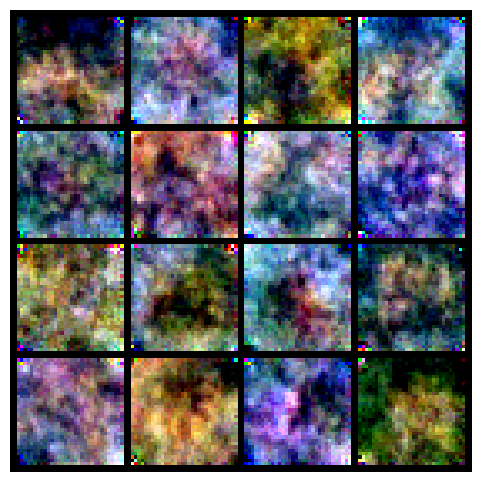

In [78]:
## Load the pre-trained checkpoint from disk.
# device = 'cuda' ['cuda', 'cpu'] {'type':'string'}
ckpt = torch.load('cream3.pth', map_location=device)
score_model.load_state_dict(ckpt)


########### Specify the digit for which to generate samples
###########
text = "dog"
digit = convert_vectors_to_fixed_size_int(digit, dtype=np.int32)
print(digit)
import torch
import numpy as np

# Пример данных

sample_batch_size = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Создаем массив NumPy



digit = 6

###########
###########



# Set the batch size for generating samples
sample_batch_size = 16
# Set the number of steps for the Euler-Maruyama sampler
num_steps = 1500
# Choose the sampler type (Euler-Maruyama, pc_sampler, ode_sampler)
sampler = Euler_Maruyama_sampler # ['Euler_Maruyama_sampler', 'pc_sampler', 'ode_sampler'] {'type': 'raw'}
# score_model.eval()

## Generate samples using the specified sampler.
samples = sampler(score_model,
        marginal_prob_std_fn,
        diffusion_coeff_fn,
        sample_batch_size,
        num_steps=num_steps,
        device=device,
        y=digit*torch.ones(sample_batch_size, dtype=torch.long))
print(y)
## Sample visualization.
samples = samples.clamp(0.0, 1.0)
%matplotlib inline
import matplotlib.pyplot as plt
# Create a grid of samples for visualization
sample_grid = make_grid(samples, nrow=int(np.sqrt(sample_batch_size)))

# Plot the generated samples
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(sample_grid.permute(1, 2, 0).cpu(), vmin=0., vmax=1.)
plt.show()

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # CLIP ожидает изображения 224x224
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))  # Нормализация для CLIP
])


In [ ]:
import torch
from PIL import Image
from transformers import CLIPModel, CLIPProcessor

# Проверяем, доступен ли GPU, и выбираем устройство
device = "cuda" if torch.cuda.is_available() else "cpu"

# Загрузка предобученной модели CLIP и процессора
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Пример изображений (загрузите свои изображения)
image1 = Image.open("image1.jpg")  # Загрузите изображение 1
image2 = Image.open("image2.jpg")  # Загрузите изображение 2
images = [image1, image2]  # Список изображений

# Текстовые описания
texts = [
"a photo of a dog"
]

# Подготовка изображений и текстов
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True).to(device)

# Получение эмбеддингов для изображений и текстов
with torch.no_grad():
    image_features = model.get_image_features(inputs["pixel_values"])
    text_features = model.get_text_features(inputs["input_ids"], inputs["attention_mask"])

# Нормализация эмбеддингов
image_features = image_features / image_features.norm(dim=-1, keepdim=True)
text_features = text_features / text_features.norm(dim=-1, keepdim=True)

# Вычисление косинусного сходства между изображениями и текстами
similarity = (image_features @ text_features.T) * 100  # Масштабируем для удобства чтения

# Применяем softmax для получения вероятностей
similarity = similarity.softmax(dim=-1)

# Вывод результатов
for i, image in enumerate(images):
    print(f"Сходство для изображения {i+1}:")
    for j, text in enumerate(texts):
        print(f"  Текст '{text}': {similarity[i][j].item():.4f}")

In [ ]:
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt

# Загрузка предобученной модели CLIP и токенизатора
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Функция для оценки тензоров по текстовой подсказке
def evaluate_tensors_with_clip(tensors, text_prompt, model, preprocess, device):
    # Токенизация текстовой подсказки
    text = clip.tokenize([text_prompt]).to(device)

    # Обработка тензоров и получение их фич
    image_features = []
    for tensor in tensors:
        # Преобразование тензора в изображение и предобработка
        image = preprocess(Image.fromarray(tensor.numpy())).unsqueeze(0).to(device)
        with torch.no_grad():
            image_feature = model.encode_image(image)
        image_features.append(image_feature)

    # Получение текстовых фич
    with torch.no_grad():
        text_features = model.encode_text(text)

    # Вычисление схожести между текстовыми и изображенческими фичами
    similarities = []
    for image_feature in image_features:
        similarity = torch.nn.functional.cosine_similarity(image_feature, text_features)
        similarities.append(similarity.item())

    # Нахождение индекса самого подходящего тензора
    best_index = similarities.index(max(similarities))

    return best_index, similarities

# Пример использования
if __name__ == "__main__":
    # Создание случайных тензоров (предположим, что это изображения)
    img.cpu()
    tensors = img

    # Текстовая подсказка
    text_prompt = "dog"

    # Оценка тензоров
    best_index, similarities = evaluate_tensors_with_clip(tensors, text_prompt, model, preprocess, device)

    # Визуализация самого подходящего тензора
    best_tensor = tensors[best_index]
    plt.imshow(best_tensor.permute(1, 3, 0))
    plt.title(f"Best tensor (similarity: {similarities[best_index]:.2f})")
    plt.show()